# Libraries

In [1]:
#import relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape, Conv2DTranspose, Embedding, UpSampling2D, concatenate, Multiply, Add, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import cv2

2022-10-26 21:20:06.178908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Loader, Writers

In [12]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image(data_loc, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    data = np.load(data_loc)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

#Display some test images from the test set of tiny-imagenet
def display_usps_image(data, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

$$\bf A. \space MNIST \space - \space USPS \space data$$

In [16]:
#numpy function
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    
def read_usps_dataset(filename):
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = (255*train.get('data')[:]).astype('uint8')
        #data is of 16x16 shape
        X = []
        X2 = []
        X_tr = X_tr.reshape((X_tr.shape[0], 16, 16))
        #padding from 16 to 28 
        for i in range(X_tr.shape[0]):
            X.append(np.pad(X_tr[i], 6, pad_with, padder=0))
        X_tr = np.array(X)
        X_tr = np.expand_dims(X_tr, axis=3)
        y_tr = train.get('target')[:]
        test = hf.get('test')
        
        X_te = (255*test.get('data')[:]).astype('uint8')
        X_te = X_te.reshape((X_te.shape[0], 16, 16))
        #padding from 16 to 28
        for i in range(X_te.shape[0]):
            X2.append(np.pad(X_te[i], 6, pad_with, padder=0))
            
        X_te = np.array(X2)
        X_te = np.expand_dims(X_te, axis=3)
        y_te = test.get('target')[:]
        #make it 3 channel
        X_te = np.repeat(X_te, 3, axis=3)
        X_tr = np.repeat(X_tr, 3, axis=3)
    return X_tr, y_tr, X_te, y_te


X_train_usps, y_train_usps, X_test_usps, y_test_usps = read_usps_dataset("../MNIST_USPS/usps.h5")
print("USPS train dataset shape: X ={}, y={}".format(X_train_usps.shape, y_train_usps.shape))
print("USPS test dataset shape: X ={}, y={}".format(X_test_usps.shape, y_test_usps.shape))

USPS train dataset shape: X =(7291, 28, 28, 3), y=(7291,)
USPS test dataset shape: X =(2007, 28, 28, 3), y=(2007,)


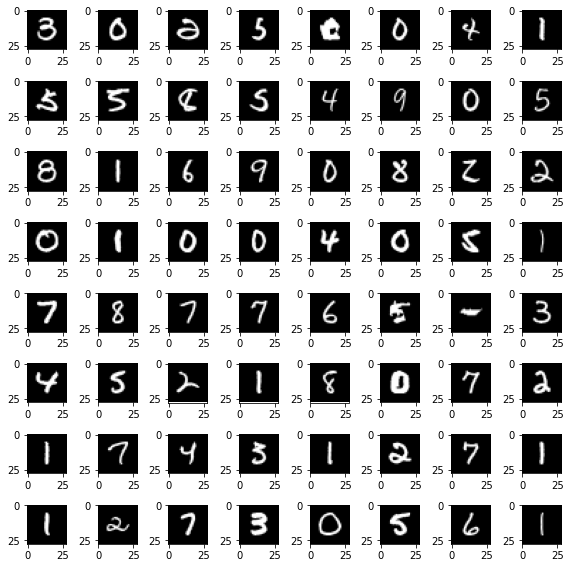

Image dimension in the dataset:  (28, 28, 3)
[0 1 2 3 4 5 6 7 8 9]


In [17]:
display_usps_image(X_test_usps, 8, 8)
print(np.unique(y_train_usps))

Mnist train dataset shape: X =(60000, 28, 28, 3), y=(60000,)
Mnist test dataset shape: X =(10000, 28, 28, 3), y=(10000,)


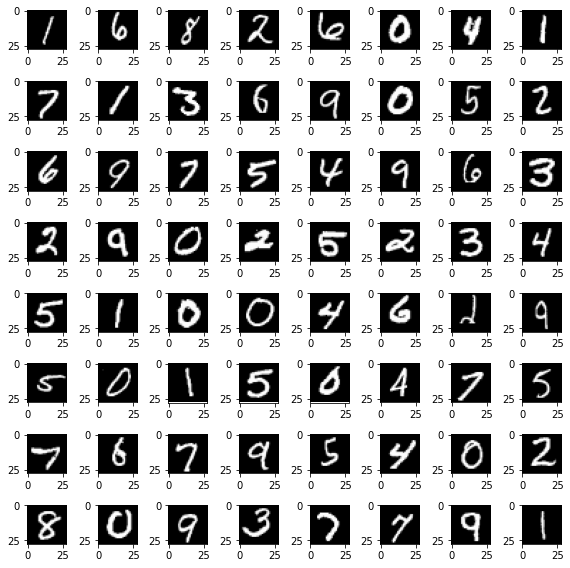

Image dimension in the dataset:  (28, 28, 3)
[0 1 2 3 4 5 6 7 8 9]


In [7]:
def read_mnist_dataset():
    (X_tr, y_tr), (X_te, y_te) = mnist.load_data()
    X_tr = np.expand_dims(X_tr, axis=3)
    X_tr = np.repeat(X_tr, 3, axis=3)
    X_te = np.expand_dims(X_te, axis=3)
    X_te = np.repeat(X_te, 3, axis=3)
    return X_tr.astype('uint8'), y_tr, X_te.astype('uint8'), y_te

X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist = read_mnist_dataset()
print("Mnist train dataset shape: X ={}, y={}".format(X_train_mnist.shape, y_train_mnist.shape))
print("Mnist test dataset shape: X ={}, y={}".format(X_test_mnist.shape, y_test_mnist.shape))
display_usps_image(X_train_mnist, 8, 8)
print(np.unique(y_train_mnist))

$$\bf B. \space ClipArt \space - \space Real \space (Office-Home) $$

In [10]:
#converts it to 128x128x3 image
w = h = 128
def make_all_shapes_uniform(image):
    return cv2.resize(image, (w, h), interpolation=cv2.INTER_CUBIC)
    
def save_raw_data_office_home(dataloc, saveloc):
    folders = os.listdir(dataloc)
    #train set
    X_train = np.array([], dtype='uint8').reshape(0, w, h, 3)
    y_train = np.array([], dtype='uint8')
    #test set
    X_test = np.array([], dtype='uint8').reshape(0, w, h, 3)
    y_test = np.array([], dtype='uint8')
    label_list = open(saveloc+"label_index.txt", 'w')
    #for all the categories of the dataset
    split_ratio = 0.2
    
    categories = os.listdir(dataloc)
    ctr = 0
    for cat_name in categories:
        #only directories
        if not os.path.isdir(dataloc+cat_name):
            continue
            
        img_names = os.listdir(dataloc+cat_name+"/")
        num_images = len(img_names)
        X = []
        #saving the labels
        list_test = np.random.choice(num_images, size=int(0.2*num_images), replace=False)
        
        y_test = np.append(y_test, ((np.ones(int(0.2*num_images))*ctr).astype('uint8')))
        y_train = np.append(y_train, (np.ones(num_images - int(0.2*num_images))*ctr).astype('uint8'))
        print("{} ---> {}\n:".format(ctr, cat_name), file=label_list, flush=True)
        
        #list images
        for img in img_names:
            
            img = img_to_array(load_img(dataloc+cat_name+"/"+img)).astype('uint8')
            img = make_all_shapes_uniform(img) 
            
            X.append(img)
        
        X = np.array(X)
        
        #do something here
        X_test = np.append(X_test, X[list_test], axis=0)
        #remove the test examples
        X = np.delete(X, list_test, axis=0)
        X_train = np.append(X_train, X, axis=0)
        ctr += 1
    
    X_train = np.array(X_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    print("Train X size = {}, Train y size = {}".format(X_train.shape, y_train.shape))
    print("Test X size = {}, Test y size = {}".format(X_test.shape, y_test.shape))
    with open(saveloc+"train_X.npy", 'wb') as fptr:
        np.save(fptr, X_train)
    with open(saveloc+"test_X.npy", 'wb') as fptr:
        np.save(fptr, X_test)
    with open(saveloc+"train_y.npy", 'wb') as fptr:
        np.save(fptr, y_train)
    with open(saveloc+"test_y.npy", 'wb') as fptr:
        np.save(fptr, y_test)
        
    label_list.close()

#save_raw_data_office_home("../OfficeHomeDataset/Real World/", "../OfficeHomeDataset/Real World/")
#save_raw_data_office_home("../OfficeHomeDataset/Clipart/", "../OfficeHomeDataset/Clipart/")

Real World Data


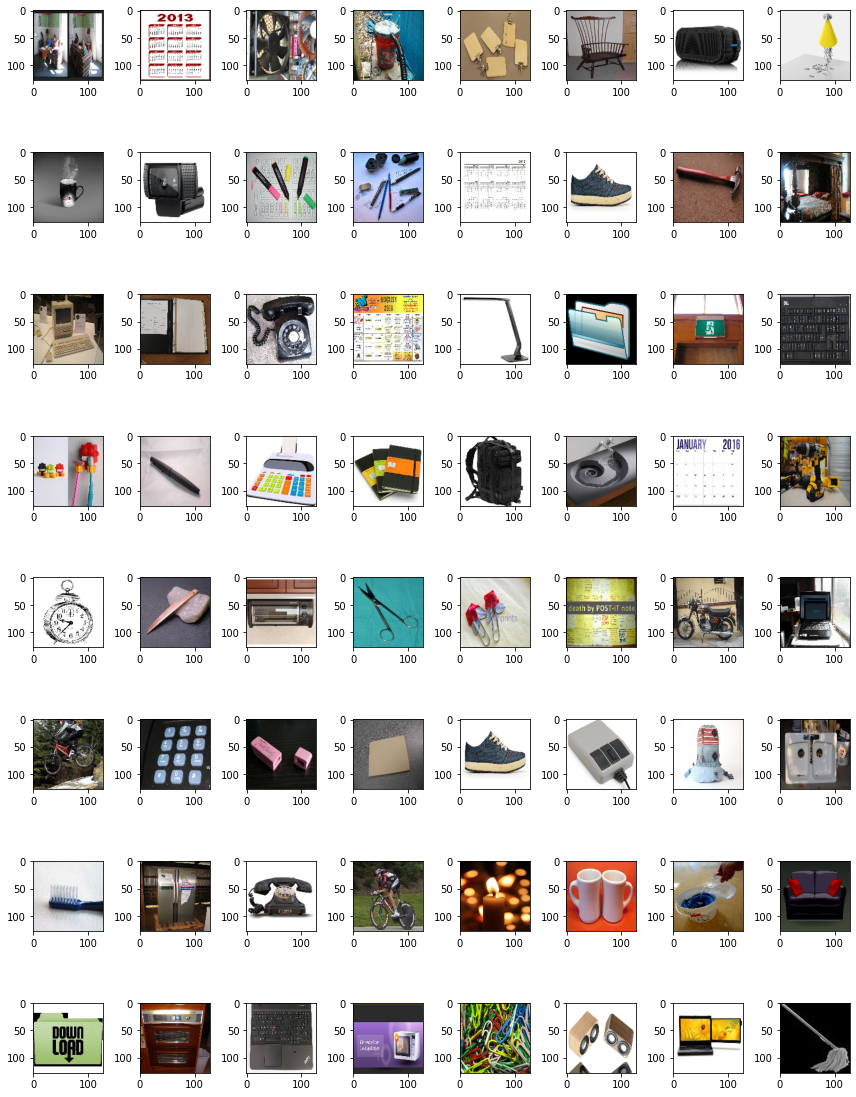

Image dimension in the dataset:  (128, 128, 3)
Clipart Data


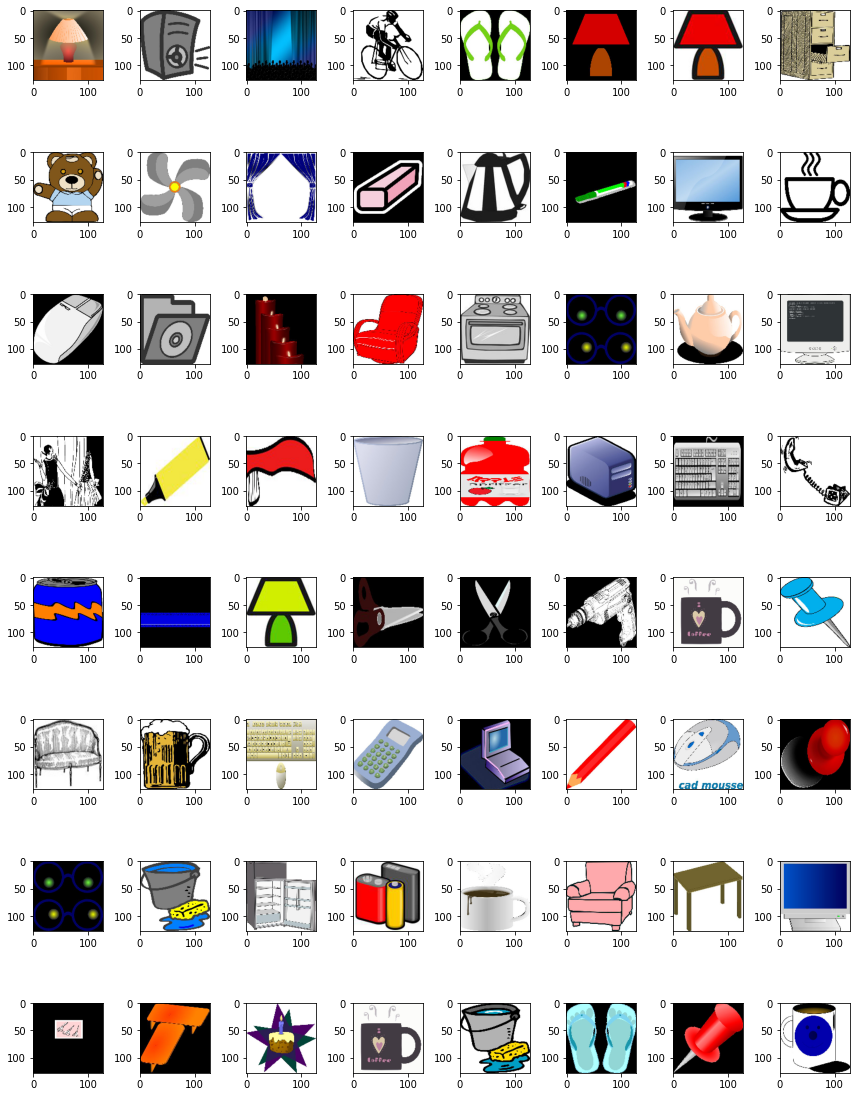

Image dimension in the dataset:  (128, 128, 3)


In [13]:
print("Real World Data")
display_formatted_image("../OfficeHomeDataset/Real World/train_X.npy", 8, 8)
print("Clipart Data")
display_formatted_image("../OfficeHomeDataset/Clipart/test_X.npy", 8, 8)

# Model

In [20]:
class Model_Resnet(object):
    def __init__(self, input_shape, num_classes):
        #make the Resnet 
        self.input_shape = input_shape
        self.num_classes = num_classes
        inp = Input([None, None, 3], dtype = tf.float32, name='Resnet_input')
        
        prep_inp = preprocess_input(inp)
        rnet50 = ResNet50(include_top=True, weights=None, input_tensor=inp, input_shape=None, pooling=None, classes=num_classes)
        out = rnet50(prep_inp)
        self.model = Model(inputs=inp, outputs=out)
        self.model.summary()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_RESNET(self, train_X, train_y, ep=5, bs=128):
        self.model.fit(train_X, tf.one_hot(train_y, self.num_classes) , epochs=ep, batch_size=bs)
        
    def test_cross_generalization(self, test_X, test_y):
        results = self.model.evaluate(test_X, tf.one_hot(test_y, self.num_classes))
        return results

# Experiment and Results

In [58]:
#inspired from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#plotter
def plot_accuracies_3group(train_acc, test_acc, cross_acc, baseline, labels, legends, __title__):
    
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    rects1 = ax.bar(x - width, train_acc, width, label=legends[0])
    rects2 = ax.bar(x, test_acc, width, label=legends[1])
    rects3 = ax.bar(x + width, cross_acc, width, label=legends[2])
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=20)
    ax.set_title(__title__, fontsize=25)
    ax.set_xticks(x, labels, fontsize=20)
    ax.axhline(y = baseline, color='black', linestyle = '--')
    
    ax.legend(fontsize=20)
    
    ax.bar_label(rects1, fontsize=20, padding=3)
    ax.bar_label(rects2, fontsize=20, padding=3)
    ax.bar_label(rects3, fontsize=20, padding=3)
    
    fig.tight_layout()

    plt.show()

$$\bf A. \space MNIST \space - \space USPS \space data$$

#Self Model: USPS

In [20]:
my_model_usps = Model_Resnet((28, 28, 3), 10)
#all values must be in between [0, 255] : Resnet preprocessing requirement
my_model_usps.train_RESNET(X_train_usps.astype('float32'), y_train_usps)
accuracy_self_usps = my_model_usps.test_cross_generalization(X_test_usps.astype('float32'), y_test_usps)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet_input (InputLayer)    [(None, None, None, 3)]   0         
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_5 (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 10)                23608202  
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 7s 44ms/step - loss: 1.8347 - accuracy: 0.5804
Epoch 2/5
57/57 [==============================] - 2s 43ms/step - loss: 0.1458 - accuracy: 0.9573
Epoch 3/5
57/57 [===========================

#Cross Generalization

In [92]:
accuracy_cross_mnist = my_model_usps.test_cross_generalization(X_test_mnist, y_test_mnist)

313/313 [==============================] - 3s 11ms/step - loss: 1.2391 - accuracy: 0.6209


#Self Model: MNIST

In [90]:
my_model_mnist = Model_Resnet((28, 28, 3), 10)
my_model_mnist.train_RESNET(X_train_mnist, y_train_mnist)
accuracy_self_mnist = my_model_mnist.test_cross_generalization(X_test_mnist, y_test_mnist)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet_input (InputLayer)    [(None, None, None, 3)]   0         
_________________________________________________________________
tf.__operators__.getitem_14  (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_14 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 10)                23608202  
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 25s 44ms/step - loss: 0.7533 - accuracy: 0.8168
Epoch 2/5
469/469 [==============================] - 20s 43ms/step - loss: 0.0746 - accuracy: 0.9777
Epoch 3/5
469/469 [==================

In [91]:
accuracy_cross_usps = my_model_mnist.test_cross_generalization(X_test_usps, y_test_usps)

63/63 [==============================] - 1s 11ms/step - loss: 0.3263 - accuracy: 0.9068


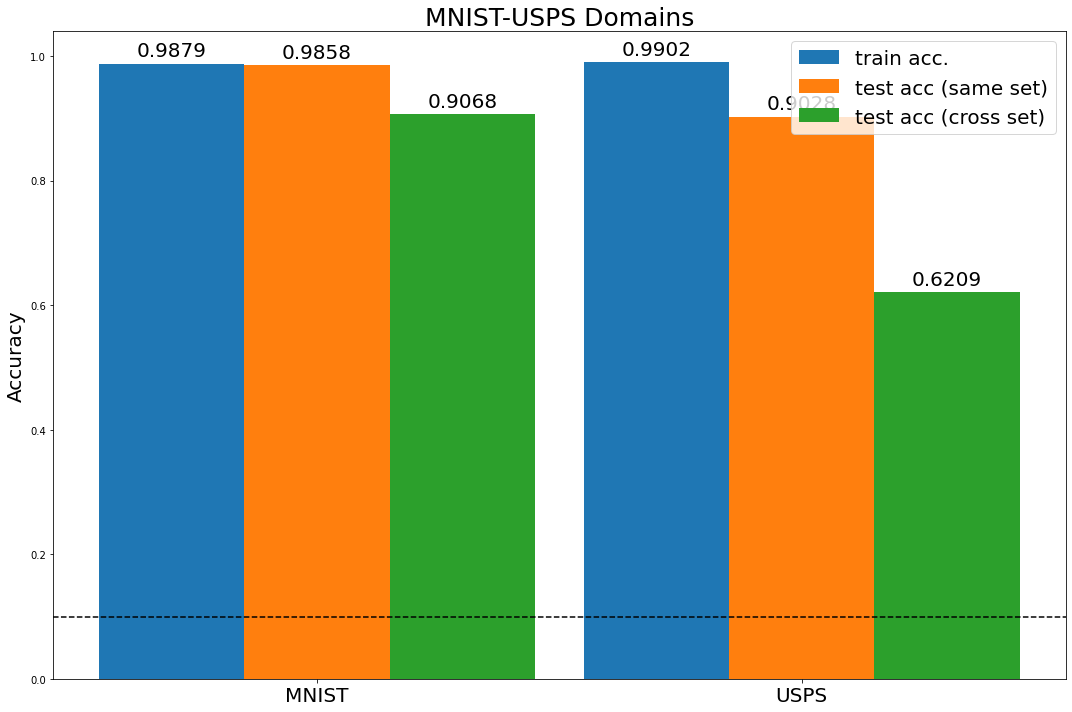

In [59]:
#plot details
plot_accuracies_3group([0.9879, 0.9902], [0.9858, 0.9028], [0.9068, 0.6209], 0.1, ['MNIST', 'USPS'], ['train acc.', 'test acc (same set)', 'test acc (cross set)'], "MNIST-USPS Domains")

$$\bf B. \space ClipArt \space - \space Real \space (Office-Home) $$

In [18]:
#load the real data 
X_train_real = np.load("../OfficeHomeDataset/Real World/train_X.npy") 
y_train_real = np.load("../OfficeHomeDataset/Real World/train_y.npy")
X_test_real = np.load("../OfficeHomeDataset/Real World/test_X.npy")
y_test_real = np.load("../OfficeHomeDataset/Real World/test_y.npy")
print("Real Data")
print("Train X size = {}, Train y size = {}".format(X_train_real.shape, y_train_real.shape))
print("Test X size = {}, Test y size = {}".format(X_test_real.shape, y_test_real.shape))
#load the clipart data
X_train_clip = np.load("../OfficeHomeDataset/Clipart/train_X.npy")
y_train_clip = np.load("../OfficeHomeDataset/Clipart/train_y.npy")
X_test_clip = np.load("../OfficeHomeDataset/Clipart/test_X.npy")
y_test_clip = np.load("../OfficeHomeDataset/Clipart/test_y.npy")
print("Clipart Data")
print("Train X size = {}, Train y size = {}".format(X_train_clip.shape, y_train_clip.shape))
print("Test X size = {}, Test y size = {}".format(X_test_clip.shape, y_test_clip.shape))

Real Data
Train X size = (3511, 128, 128, 3), Train y size = (3511,)
Test X size = (846, 128, 128, 3), Test y size = (846,)
Clipart Data
Train X size = (3519, 128, 128, 3), Train y size = (3519,)
Test X size = (846, 128, 128, 3), Test y size = (846,)


#Self Model: Real Data

In [37]:
#number of unique labels is 65
my_model_rw = Model_Resnet((128, 128, 3), 65)
#all values must be in between [0, 255] : Resnet preprocessing requirement
my_model_rw.train_RESNET(X_train_real.astype('float32'), y_train_real, 200, 128)
accuracy_self_rw = my_model_rw.test_cross_generalization(X_test_real.astype('float32'), y_test_real)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet_input (InputLayer)    [(None, None, None, 3)]   0         
_________________________________________________________________
tf.__operators__.getitem_10  (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_10 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 65)                23720897  
Total params: 23,720,897
Trainable params: 23,667,777
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 14s 221ms/step - loss: 5.4710 - accuracy: 0.0280
Epoch 2/200
28/28 [==============================] - 6s 222ms/step - loss: 4.1743 - accuracy: 0.0884
Epoch 3/200
28/28 [=================

28/28 [==============================] - 6s 227ms/step - loss: 0.0045 - accuracy: 0.9966
Epoch 152/200
28/28 [==============================] - 6s 227ms/step - loss: 0.0052 - accuracy: 0.9963
Epoch 153/200
28/28 [==============================] - 6s 229ms/step - loss: 0.0044 - accuracy: 0.9959
Epoch 154/200
28/28 [==============================] - 6s 225ms/step - loss: 0.0060 - accuracy: 0.9954
Epoch 155/200
28/28 [==============================] - 6s 224ms/step - loss: 0.0059 - accuracy: 0.9952
Epoch 156/200
28/28 [==============================] - 6s 228ms/step - loss: 0.0039 - accuracy: 0.9968
Epoch 157/200
28/28 [==============================] - 6s 224ms/step - loss: 0.0084 - accuracy: 0.9940
Epoch 158/200
28/28 [==============================] - 6s 229ms/step - loss: 0.0583 - accuracy: 0.9830
Epoch 159/200
28/28 [==============================] - 6s 224ms/step - loss: 2.4471 - accuracy: 0.4522
Epoch 160/200
28/28 [==============================] - 6s 226ms/step - loss: 1.6050 - a

#Cross Generalisation

In [38]:
accuracy_cross_clip = my_model_rw.test_cross_generalization(X_test_clip, y_test_clip)

27/27 [==============================] - 2s 26ms/step - loss: 9.5964 - accuracy: 0.1158


#Self Model: Clip Art

In [40]:
#number of unique labels is 65
my_model_clip = Model_Resnet((128, 128, 3), 65)
#all values must be in between [0, 255] : Resnet preprocessing requirement
my_model_clip.train_RESNET(X_train_clip.astype('float32'), y_train_clip, 50, 128)
accuracy_self_clip = my_model_clip.test_cross_generalization(X_test_clip.astype('float32'), y_test_clip)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet_input (InputLayer)    [(None, None, None, 3)]   0         
_________________________________________________________________
tf.__operators__.getitem_12  (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_12 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 65)                23720897  
Total params: 23,720,897
Trainable params: 23,667,777
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/50
28/28 [==============================] - 10s 221ms/step - loss: 5.6924 - accuracy: 0.0255
Epoch 2/50
28/28 [==============================] - 6s 222ms/step - loss: 4.4061 - accuracy: 0.0651
Epoch 3/50
28/28 [====================

#Cross Generalization

In [41]:
accuracy_cross_rw = my_model_clip.test_cross_generalization(X_test_real, y_test_real)

27/27 [==============================] - 2s 25ms/step - loss: 7.8492 - accuracy: 0.0827


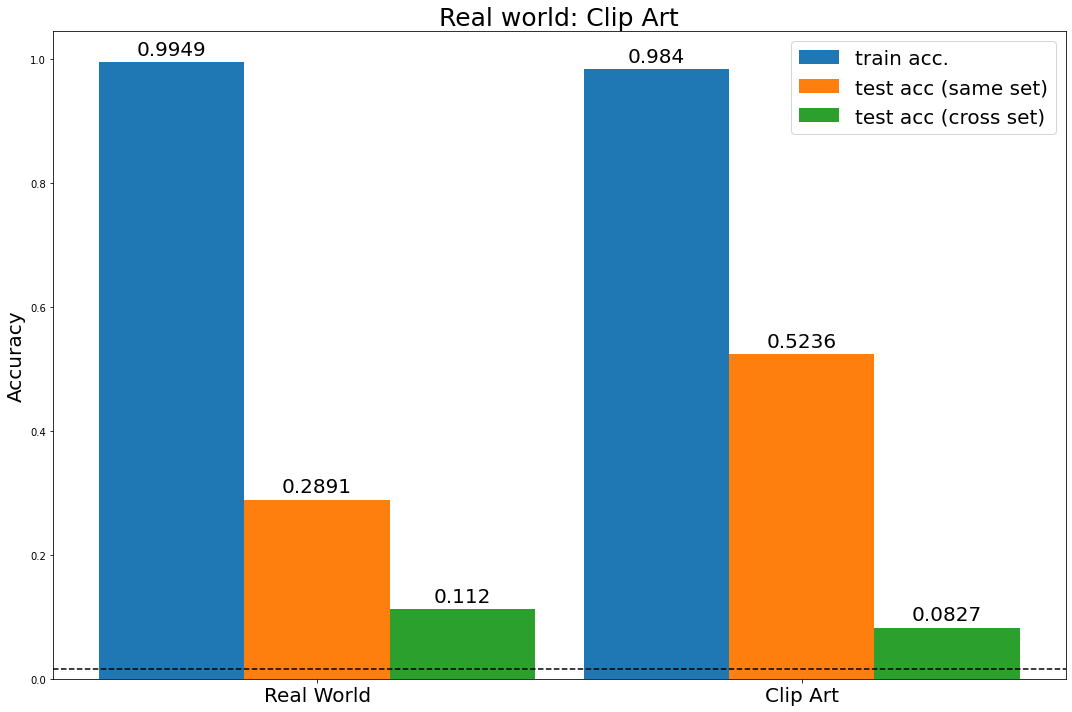

In [60]:
#plot details
plot_accuracies_3group([0.9949, 0.9840], [0.2891, 0.5236], [0.112, 0.0827], 0.01538, ['Real World', 'Clip Art'], ['train acc.', 'test acc (same set)', 'test acc (cross set)'], "Real world: Clip Art")